In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
category = pd.read_csv('/content/drive/MyDrive/DM2/category_hierarchy.csv', sep="|")
orders = pd.read_csv('/content/drive/MyDrive/DM2/orders.csv', sep="|")
items = pd.read_csv('/content/drive/MyDrive/DM2/items.csv', sep="|")

**Number of unique values**

In [3]:
orders.nunique()

date        245
userID    46138
itemID    31756
order        51
dtype: int64

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071538 entries, 0 to 1071537
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   date    1071538 non-null  object
 1   userID  1071538 non-null  int64 
 2   itemID  1071538 non-null  int64 
 3   order   1071538 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 32.7+ MB


In [5]:
orders["date"] = pd.to_datetime(orders["date"])
orders["week of month"] = orders["date"].apply(lambda d: (d.day-1) // 7 + 1)
orders["week of month"] = orders["week of month"].replace(to_replace=5, value=0)
orders.head()

,date,userID,itemID,order,week of month
0,2020-06-01,38769,3477,1,1
1,2020-06-01,42535,30474,1,1
2,2020-06-01,42535,15833,1,1
3,2020-06-01,42535,20131,1,1
4,2020-06-01,42535,4325,1,1


In [6]:
item_orders = pd.merge(orders, items, how="left", on="itemID")
item_orders.head()

,date,userID,itemID,order,week of month,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories
0,2020-06-01,38769,3477,1,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]"
1,2020-06-01,42535,30474,1,1,193,10,3,229,3,132,"[3459, 3738, 679, 1628, 4072]"
2,2020-06-01,42535,15833,1,1,1318,4,1,455,0,108,"[2973, 2907, 2749, 3357]"
3,2020-06-01,42535,20131,1,1,347,4,0,291,3,44,"[30, 1515, 1760, 2932, 1287, 2615, 3727, 2450,..."
4,2020-06-01,42535,4325,1,1,539,6,0,303,0,45,"[3104, 1772, 2029, 1274, 3915, 888, 1118, 3882..."


In [7]:
item_sales_per_week = item_orders.groupby(by=['week of month', 'itemID'])['order'].sum().reset_index()
item_sales_per_week.sample(10)

,week of month,itemID,order
71741,3,21946,1
49977,2,21156,34
77840,3,31390,1
79939,4,1882,1
53132,2,26039,17
24111,1,13970,1
4595,0,10042,32
19895,1,7456,8
56652,2,31534,15
94767,4,25069,1


In [8]:
user_item_volume = orders.groupby(["userID", "itemID"]).size().reset_index().rename(columns={0:'count'})
user_item_volume.sort_values(by="count", ascending=False)

,userID,itemID,count
672550,34638,4935,29
137954,7109,14815,28
535335,27594,13664,26
443039,22815,10849,26
535339,27594,16624,25
...,...,...,...
318978,16434,9092,1
318979,16434,10703,1
318981,16434,11988,1
318982,16434,16362,1


In [9]:
user_item_volume["count"].value_counts()

1     782810
2      78719
3      21143
4       7643
5       3165
6       1403
7        702
8        355
9        188
10       106
11        79
12        38
13        20
14        14
15        14
17         6
19         4
16         3
21         3
23         2
20         2
26         2
28         1
22         1
25         1
29         1
18         1
Name: count, dtype: int64

In [11]:
sales_3477 = item_orders[item_orders['itemID']==3477]
sales_3477.head()

,date,userID,itemID,order,week of month,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories
0,2020-06-01,38769,3477,1,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]"
2308,2020-06-01,23570,3477,1,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]"
2486,2020-06-01,23495,3477,1,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]"
3622,2020-06-01,26073,3477,1,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]"
4648,2020-06-01,34302,3477,1,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]"


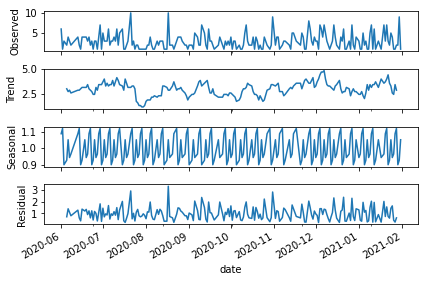

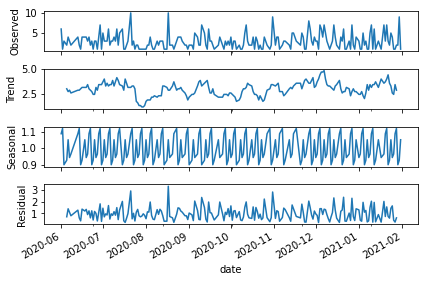

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 24*60/15*7
sales_of_3477_each_day = sales_3477.groupby('date')['order'].sum()
stats_model = seasonal_decompose(
    sales_of_3477_each_day, 
    freq=7,
    model="multiplicative",
)

stats_model.plot()